# Train Dreambooth Mask Script

Trained for 2000 steps.

1500 steps may be better, model "learns less patterns" in the random BG and clothing region. Although then for inpainting may want to use the lower guidance scale and less strength because the learning of the face is also hindered, did not try inpaitning at 1500 steps though.

In [1]:
import diffusers
import transformers
import sys
import shutil
import time
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
from compel import Compel
import torch
import os
import random
import requests
from io import BytesIO
import numpy as np
import subprocess
from torchvision import models, transforms
import dlib
from PIL import Image, ImageFilter, ImageDraw, ImageEnhance
import cv2
from pathlib import Path
import math
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instance Images

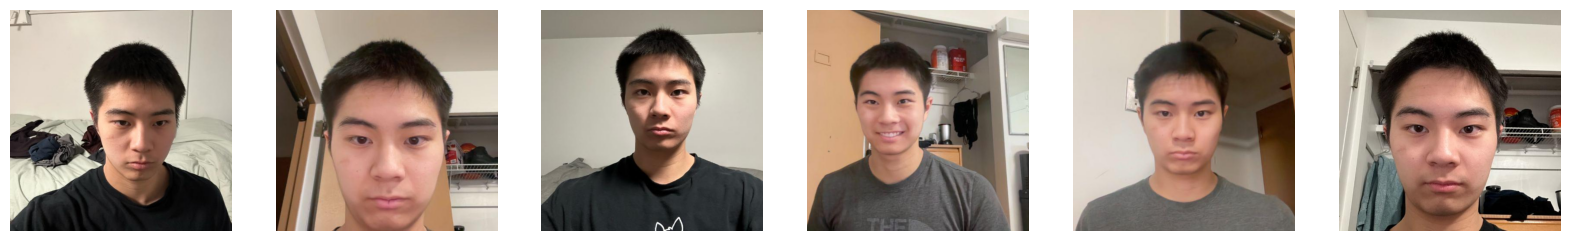

In [2]:
folder_path = 'src/user_images'

image_files = []
for file in os.listdir(folder_path):
    if file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert('RGB')
        
        if not file.lower().endswith('.jpg'):
            jpg_path = os.path.splitext(img_path)[0] + '.jpg'
            img.save(jpg_path, 'JPEG')
            os.remove(img_path)
            image_files.append(jpg_path)
        else:
            image_files.append(img_path)

images_per_row = 6
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
num_images = len(image_files)
num_rows = num_images // images_per_row + (num_images % images_per_row > 0)
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 4))
fig.subplots_adjust(hspace=0)
if num_rows == 1:
    axes = np.array([axes])
axes = axes.flatten()
for idx, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path).convert('RGB')
    axes[idx].imshow(img)
    axes[idx].axis('off')
for ax in axes[idx + 1:]:
    ax.axis('off')
plt.show()

# Train

In [ ]:
model_path = "src/models/realisticVisionV60B1_v51VAE"
dreambooth_filename = "train_dreambooth_person_mask.py"
img_folder_path = "src/user_images" 
output_dir = "ohmw_man_dreambooth"
instance_prompt = "ohmw man"
IMG_SIZE = 512
TRAINING_STEPS = 2000

process = [
    "accelerate", 
    "launch",
    f"{dreambooth_filename}",
    "--train_text_encoder",
    "--allow_tf32",
    f"--pretrained_model_name_or_path={model_path}",
    f"--instance_data_dir={img_folder_path}",
    f"--output_dir={output_dir}",
    f"--instance_prompt='{instance_prompt}'",
    f"--resolution={IMG_SIZE}",
    f"--train_batch_size=1",
    f"--gradient_accumulation_steps=1",
    "--gradient_checkpointing",
    f"--learning_rate=2e-6",
    f"--lr_scheduler=constant",
    f"--lr_warmup_steps=0",
    f"--max_train_steps={TRAINING_STEPS}",
    "--checkpointing_steps=500",


    
    # "--mixed_precision=bf16",
]

process.extend(
    [
        f"--report_to=wandb",
        f'--validation_prompt="photo of ohmw man, outdoors, in a red suit"'
        f"--num_validation_images=3",
        f"--validation_steps=50",
        f"--seed=42",
    ]
)

# Run the process
subprocess.run(process, check=True)

# Inference Functions

In [3]:
def generate_images_and_plot(prompt, num_images, steps, guidance_scale):
    model_path = "ohmw_man_dreambooth"
    pipe = StableDiffusionPipeline.from_pretrained(model_path)
    pipe = pipe.to("cuda")

    # COMPEL (add ++ if you want the token to be weighted higher)
    compel = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
    conditioning = compel.build_conditioning_tensor(prompt)

    images = []
    for seed in range(1, num_images + 1):
        result = pipe(
            prompt_embeds=conditioning,
            num_inference_steps=steps,
            generator=torch.Generator("cuda").manual_seed(seed),
            width=512,
            height=512,
            strength=1.0,
            guidance_scale=guidance_scale,
        )
        images.append(result.images[0])
    return images






def inpaint_images(images, inpaint_strength, inpaint_steps, inpaint_guidance):
    processed_images = []

    for image in images:
        # OpenCV for face detection
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(image_cv, 1.1, 4)
        
        # Continue only if a face is detected
        if len(faces) == 0:
            continue

        x, y, w, h = faces[0]
        margin = 50
        x, y, w, h = max(0, x-margin), max(0, y-margin), w+2*margin, h+2*margin
        
        # Crop the face area for segmentation
        face_area = image.crop((x, y, x+w, y+h))
        
        # Preprocessing for segmentation
        model = models.segmentation.deeplabv3_resnet101(pretrained=True)
        model.eval()
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        input_tensor = preprocess(face_area).unsqueeze(0)
        with torch.no_grad():
            output = model(input_tensor)['out'][0]
        output_predictions = output.argmax(0)
        
        mask = output_predictions.byte().cpu().numpy()
        face_mask = Image.fromarray(mask * 255)
        
        # Resize
        resized_face_area = face_area.resize((512, 512))
        resized_mask = face_mask.resize((512, 512))
        
        # Mediapipe segmentation
        import mediapipe as mp
        from mediapipe.tasks import python
        from mediapipe.tasks.python import vision
        
        resized_face_area_np = np.array(resized_face_area)
        if resized_face_area_np.dtype != np.uint8:
            resized_face_area_np = resized_face_area_np.astype(np.uint8)
        
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=resized_face_area_np)
        
        model_path = "src/models/selfie_multiclass_256x256.tflite"
        options = vision.ImageSegmenterOptions(
            base_options=mp.tasks.BaseOptions(model_asset_path=model_path),
            running_mode=vision.RunningMode.IMAGE,
            output_category_mask=True
        )
        
        with vision.ImageSegmenter.create_from_options(options) as segmenter:
            segmentation_result = segmenter.segment(mp_image)
            category_mask_np = segmentation_result.category_mask.numpy_view()
        
        face_mask = ((category_mask_np == 3) | (category_mask_np == 1) | (category_mask_np == 2))
        processed_mask = binary_closing(face_mask, structure=np.ones((3, 3)))
        person_mask_image = Image.fromarray((processed_mask * 255).astype(np.uint8))
        
        padding_size = 30
        blur_radius = 2
        padded_mask_image = Image.new('L', (person_mask_image.width + 2 * padding_size,
                                            person_mask_image.height + 2 * padding_size), color=0)
        padded_mask_image.paste(person_mask_image, (padding_size, padding_size))
        blurred_mask_image = padded_mask_image.filter(ImageFilter.GaussianBlur(blur_radius))


        # INPAINT
        checkpoint_path = "ohmw_man_dreambooth"
        
        dreamboothPipeline = StableDiffusionInpaintPipeline.from_pretrained(
            checkpoint_path,
        ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        output = dreamboothPipeline(
            prompt="photo of ohmw man",
            image=resized_face_area,
            mask_image=blurred_mask_image,
            num_inference_steps=inpaint_steps,
            strength=inpaint_strength,
            guidance_scale=inpaint_guidance,
        )
        
        inpainted_face_large = output.images[0]
        inpainted_face_original_size = inpainted_face_large.resize((w, h))
        inpainted_face_original_size = inpainted_face_original_size.convert('RGB')
        image.paste(inpainted_face_original_size, (x, y))
        
        processed_images.append(image)

    return processed_images





def plot(images):
    num_images = len(processed_images)
    rows = math.ceil(num_images / 3)
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    if num_images <= 3:
        axs = np.array([axs]).reshape(-1)
    for i, img in enumerate(processed_images):
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(f"Seed {i+1}")
        ax.axis('off')
    for j in range(i + 1, rows * 3):
        axs[j // 3, j % 3].axis('off')
    plt.show()

# Inference

In [4]:
processed_images = generate_images_and_plot("a photo of ohwm man, outdoors, crisp detail, realistic, clothed in a red colored suit++", num_images=9, steps=25, guidance_scale=7.5)

inpainted_images = inpaint_images(processed_images, inpaint_strength=0.6, inpaint_steps=30, inpaint_guidance=6)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

/home/ubuntu/virtual_env_mask_exp/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/home/ubuntu/virtual_env_mask_exp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/virtual_env_mask_exp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
I0000 00:00:1714766268.700652    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766268.920638    1144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766275.170857    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766275.222220    1164 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766281.319613    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766281.369992    1178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766287.370777    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766287.421661    1193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766293.567651    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766293.618954    1206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766299.569186    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766299.619683    1218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766305.526909    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766305.577576    1231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766311.440187    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766311.491057    1242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766317.431224    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766317.481862    1257 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

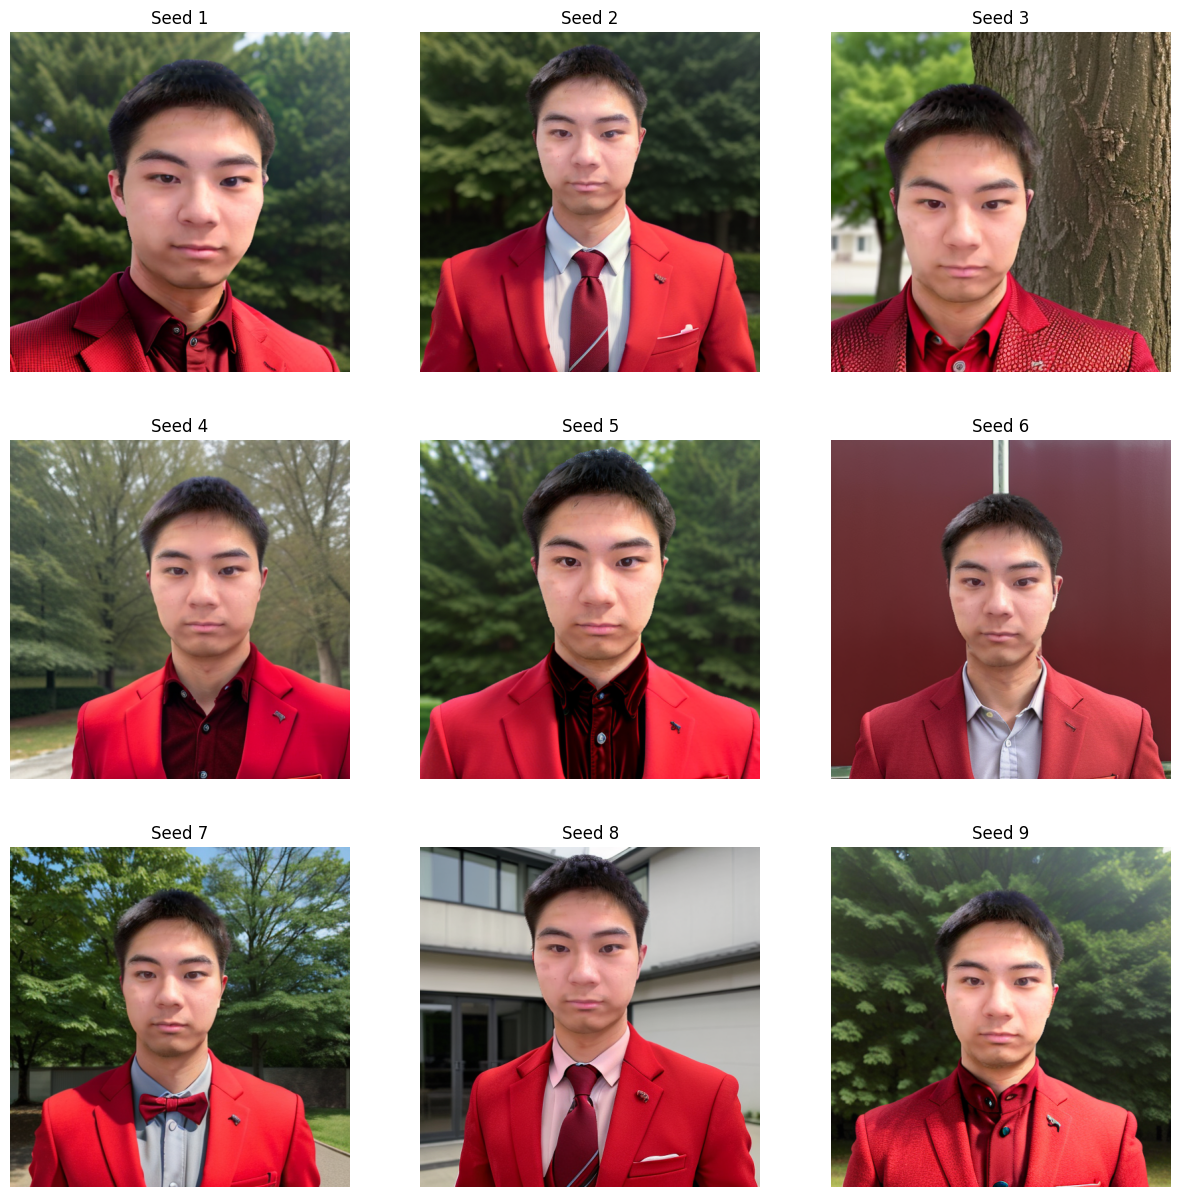

In [5]:
plot(inpainted_images)

In [6]:
processed_images = generate_images_and_plot("a photo of ohwm man, outdoors, crisp detail, realistic, clothed in a yellow colored suit++", num_images=9, steps=25, guidance_scale=7.5)

inpainted_images = inpaint_images(processed_images, inpaint_strength=0.6, inpaint_steps=30, inpaint_guidance=6)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

I0000 00:00:1714766360.704082    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766360.756022    1303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766366.847056    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766366.897870    1316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766373.099233    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766373.150052    1328 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766379.210668    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766379.261456    1340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766385.440300    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766385.491202    1351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766391.482580    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766391.533030    1362 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766397.522423    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766397.573166    1375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766403.469392    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766403.519904    1387 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

I0000 00:00:1714766409.598875    1020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714766409.649738    1400 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA A10G/PCIe/SSE2


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/18 [00:00<?, ?it/s]

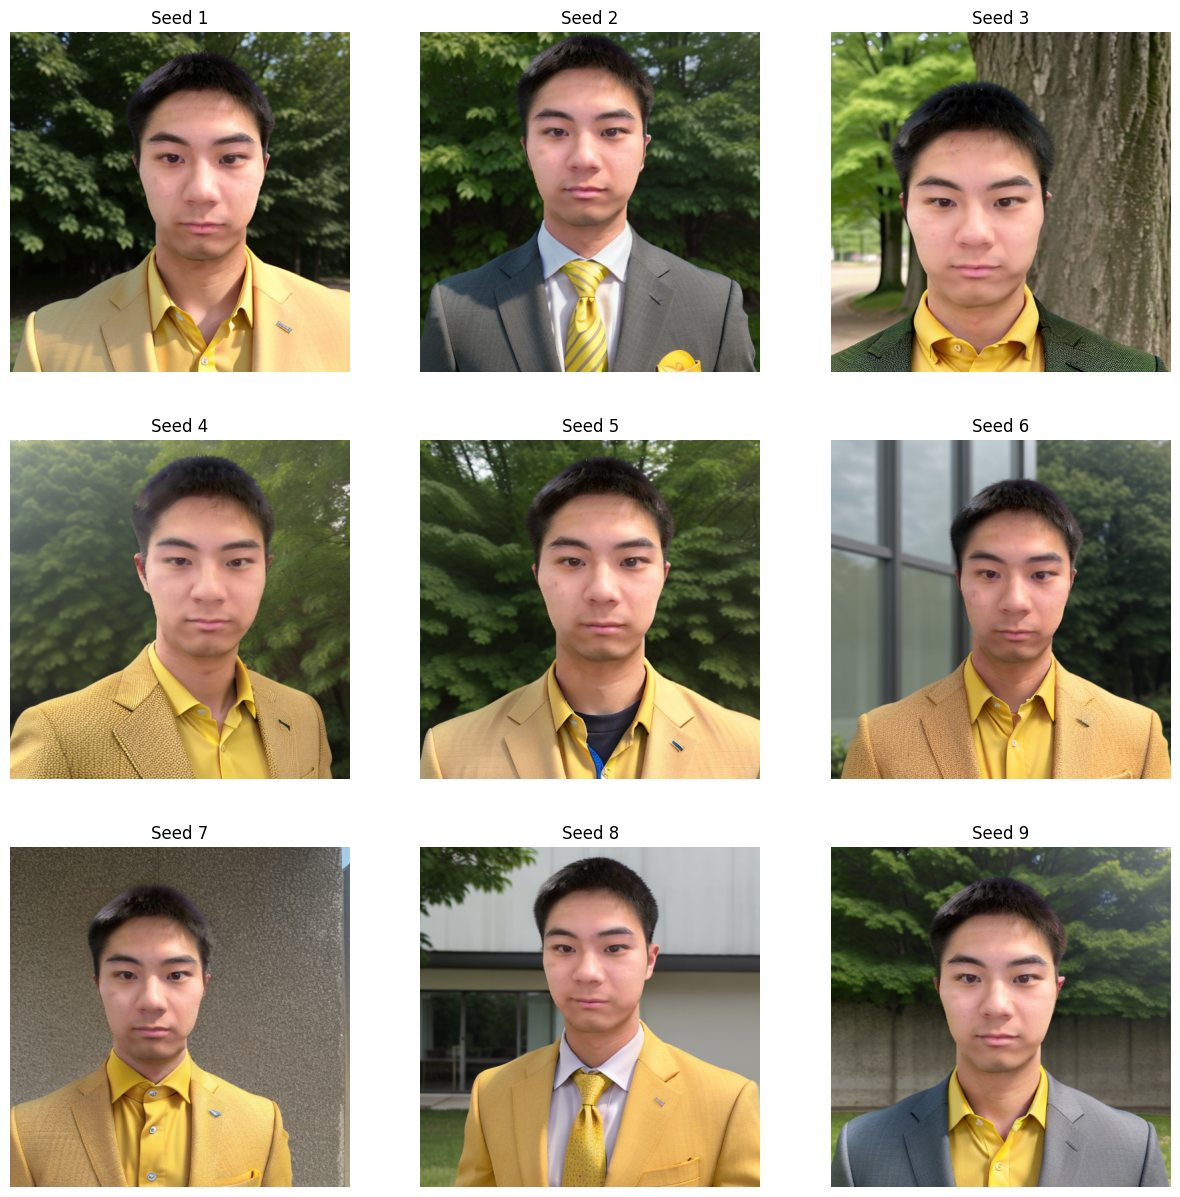

In [7]:
plot(inpainted_images)